<a href="https://colab.research.google.com/github/varunkumark1997/EVA5-Assignment/blob/master/MNIST_model_level_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target:

    Add step LR

Results:

    Parameters: 9,800
    Best Train Accuracy: 99.28
    Best Test Accuracy: 99.58

Analysis:

    The step LR has given fine tuning of the learing kernels for its value by increasing the precision of the kernel values in each EPOCH,
    hence the values moves in right direction to reach the right minima.
    We have achieved our goal accuracy and also its consistent for last few epochs.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [12]:
train_transforms = transforms.Compose(
                    [
                        transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])
                    
test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [13]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test  = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [14]:
SEED = 1

cuda = torch.cuda.is_available()
print('is CUDA available', cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

trainloader = torch.utils.data.DataLoader(train, **dataloader_args)

testloader = torch.utils.data.DataLoader(test, **dataloader_args)

is CUDA available True


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # TRANSITION BLOCK 1
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 12

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 10

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 8
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 6

        # CONVOLUTION BLOCK 3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 4
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 4
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)        
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)        
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [16]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 32, 24, 24]             512
         MaxPool2d-8           [-1, 32, 12, 12]               0
            Conv2d-9           [-1, 16, 12, 12]             512
             ReLU-10           [-1, 16, 12, 12]               0
      BatchNorm2d-11           [-1, 16, 12, 12]              32
           Conv2d-12           [-1, 16, 10, 10]           2,304
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1

In [17]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [26]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    scheduler.step()
    test(model, device, testloader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


loss=0.03007601574063301 batch_id=937 Accuracy=93.555: 100%|██████████| 938/938 [00:18<00:00, 50.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9850/10000 (98.50%)

EPOCH: 1


loss=0.09802854061126709 batch_id=937 Accuracy=98.135: 100%|██████████| 938/938 [00:18<00:00, 50.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9882/10000 (98.82%)

EPOCH: 2


loss=0.1542799323797226 batch_id=937 Accuracy=98.405: 100%|██████████| 938/938 [00:18<00:00, 50.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9901/10000 (99.01%)

EPOCH: 3


loss=0.020234061405062675 batch_id=937 Accuracy=98.595: 100%|██████████| 938/938 [00:18<00:00, 51.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9923/10000 (99.23%)

EPOCH: 4


loss=0.020947016775608063 batch_id=937 Accuracy=98.74333333333334: 100%|██████████| 938/938 [00:18<00:00, 51.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9919/10000 (99.19%)

EPOCH: 5


loss=0.0224930290132761 batch_id=937 Accuracy=98.83666666666667: 100%|██████████| 938/938 [00:18<00:00, 52.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9936/10000 (99.36%)

EPOCH: 6


loss=0.03314128518104553 batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:17<00:00, 52.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9953/10000 (99.53%)

EPOCH: 7


loss=0.047775786370038986 batch_id=937 Accuracy=99.21666666666667: 100%|██████████| 938/938 [00:17<00:00, 52.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9958/10000 (99.58%)

EPOCH: 8


loss=0.011990515515208244 batch_id=937 Accuracy=99.28666666666666: 100%|██████████| 938/938 [00:17<00:00, 53.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9956/10000 (99.56%)

EPOCH: 9


loss=0.015382342040538788 batch_id=937 Accuracy=99.275: 100%|██████████| 938/938 [00:17<00:00, 53.56it/s]



Test set: Average loss: 0.0155, Accuracy: 9957/10000 (99.57%)



Text(0.5, 1.0, 'Testing Accuracy')

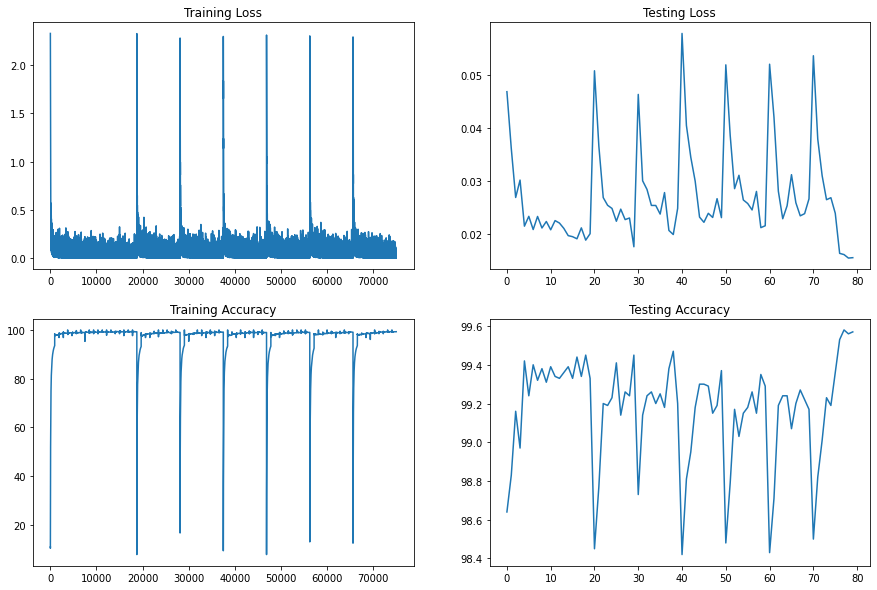

In [27]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(2, 2, figsize=(15,10))
axis[0, 0].plot(train_losses)
axis[0, 0].set_title("Training Loss")
axis[1 ,0].plot(train_acc)
axis[1, 0].set_title("Training Accuracy")
axis[0 ,1].plot(test_losses)
axis[0, 1].set_title("Testing Loss")
axis[1 ,1].plot(test_acc)
axis[1, 1].set_title("Testing Accuracy")